In [6]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
# https://www.kaggle.com/becksddf/churn-in-telecoms-dataset
df = pd.read_csv('../data/telecom_churn.csv')

In [13]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [9]:
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [10]:
df['Churn'] = df['Churn'].astype(int)

## Prepare data

In [20]:
y = df['Churn']
X_all = df.drop(columns='Churn')

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion
from dummy_transformer import DummyTransformer
from item_selector import ItemSelector
from sklearn.preprocessing import StandardScaler

In [16]:
ItemSelector?

In [18]:
df.describe(include=['object', 'bool'])

,State,International plan,Voice mail plan,Churn
count,3333,3333,3333,3333
unique,51,2,2,2
top,WV,No,No,False
freq,106,3010,2411,2850


In [23]:
num_cols = list(df.select_dtypes([np.number]).columns)
num_cols

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

In [62]:
dummy_cols = ['State', 'International plan', 'Voice mail plan']

In [24]:
X_num = X_all[num_cols]

In [ ]:
scale_pipeline = Pipeline(
    steps=[
        ('selector', ItemSelector(key=num_cols)),
        ("scaling", StandardScaler())
    ])

## Create quick model (numeric only)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=.2)

In [132]:
X_train.shape

(2666, 16)

In [133]:
y_train.shape

(2666,)

In [134]:
num_pipeline = Pipeline(
    steps=[
        ('selector', ItemSelector(key=num_cols)),
        ("scaling", StandardScaler()),
        ("estimator", LogisticRegression(C=10))
    ])

In [135]:
num_pipeline.fit(X_train, y_train)

/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('selector',
                 ItemSelector(key=['Account length', 'Area code',
                                   'Number vmail messages', 'Total day minutes',
                                   'Total day calls', 'Total day charge',
                                   'Total eve minutes', 'Total eve calls',
                                   'Total eve charge', 'Total night minutes',
                                   'Total night calls', 'Total night charge',
                                   'Total intl minutes', 'Total intl calls',
                                   'Total intl charge',
                                   'Customer service calls'])),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                

In [136]:
y_pred = num_pipeline.predict(X_test)

## Make model better

In [137]:
dt = DummyTransformer(columns_to_dummies=dummy_cols)

ohe_pipeline = Pipeline(
    steps=[
        ("select", ItemSelector(key=dummy_cols)),
        ("dummy", dt),
    ])

In [138]:
scale_pipeline = Pipeline(
    steps=[
        ('selector', ItemSelector(key=num_cols)),
        ("scaling", StandardScaler()),
    ])

In [139]:
data_prep_pipe = FeatureUnion([
    ("scaling", scale_pipeline),
    ("ohe", ohe_pipeline)
])

In [140]:
data_prep_pipe.fit_transform(X_all).shape

/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))


(3333, 71)

In [141]:
# from sklearn.ensemble import RandomForestClassifier

In [142]:
estimator_pipeline = Pipeline(steps=[
    ("prepare", data_prep_pipe),
    ("predict", LogisticRegression())
])

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=.2)

In [145]:
estimator_pipeline = estimator_pipeline.fit(X_train, y_train)

/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))
/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [146]:
y_pred = estimator_pipeline.predict(X_test)

/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))


In [147]:
# dummy_columns=list(dt.transform(X_train[['Region']].head()).columns)
# dummy_columns

## Evaluate

In [148]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
    f1_score, precision_score, recall_score, confusion_matrix

In [149]:
accuracy_score(y_test, y_pred)

0.8605697151424287

In [150]:
confusion_matrix(y_test, y_pred)

array([[550,  17],
       [ 76,  24]])

In [151]:
roc_auc_score(y_test, y_pred)

0.6050088183421517

### ROC curve

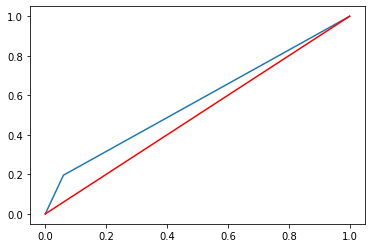

In [130]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr);
plt.plot(np.linspace(0,1), np.linspace(0,1), color='red');

In [103]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator_pipeline, X_train, y_train, cv=5, scoring='roc_auc');
print(np.mean(scores))

/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))
/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))
/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be

0.9019749986855251


/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))
/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(CategoricalDtype(categories=self.train_data_categories[col]))
/Users/nickkon/projects/pet/ITEA/Lection_4/dummy_transformer.py:63: SettingWithCopyWarning: 
A value is trying to be